In [1]:
# EDA 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Working Directories, Files, and downloading data from URL
from pathlib import Path
from urllib import request
import os
import tarfile
import pickle

# Data Sampling
from sklearn.model_selection import train_test_split
# Data Pipelines Transformation
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
# ML Models
from sklearn.linear_model import LinearRegression # ML model
from sklearn.ensemble import RandomForestRegressor
# Model Evaluations
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
# Hyper Parameter Tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

##### Using pd.read_csv("datasets/housing.csv"), the raw housing information stored in a CSV file is carefully read and transformed into a structured table called data, where every row represents a house and every column holds one of its features.


In [2]:
data = pd.read_csv('House Price Prediction/housing.csv')

In [3]:
data.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
# Checking what kind of values each column in your DataFrame holds.
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [5]:
# This line is checking how often each category of ocean_proximity appears in the data.
data["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
#Checking Missing Values
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
#Checking Duplicated Values
data.duplicated().value_counts()

False    20640
Name: count, dtype: int64

In [8]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [9]:
# the column ocean_proximity is officially treated as a categorical feature instead of plain text.

data['ocean_proximity'] = data['ocean_proximity'].astype('category')

In [10]:
# A quick health report of the whole dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


<Axes: xlabel='longitude', ylabel='latitude'>

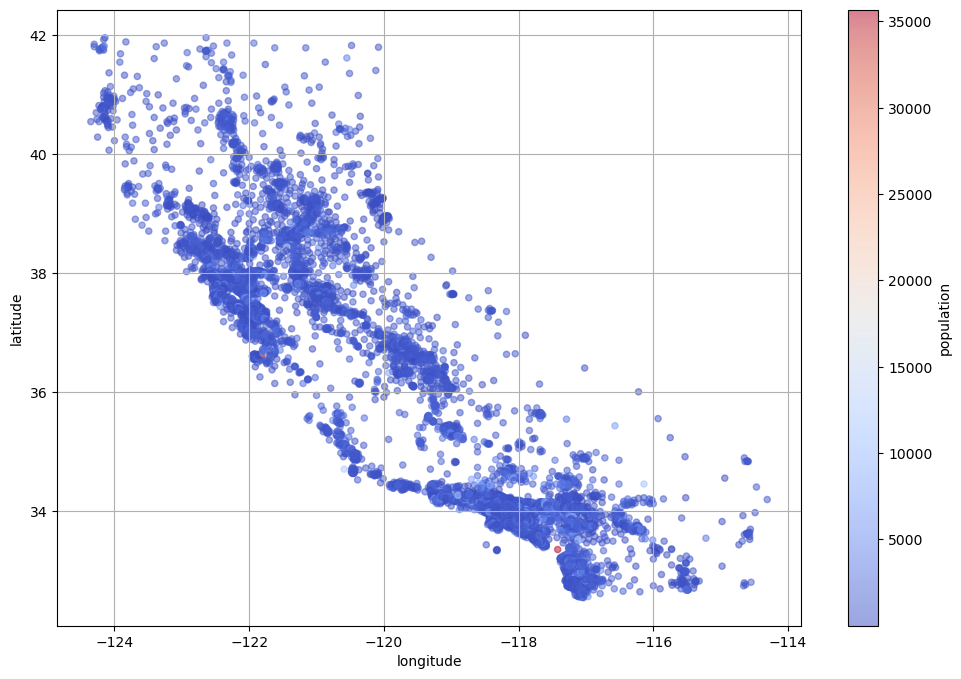

In [11]:
# drawing a geographical scatter plot of the houses on a 2D map of California using their coordinates.
data.plot(figsize=(12,8),cmap='coolwarm' ,c='population',x='longitude',y='latitude',kind='scatter',alpha=0.5,grid=True,)

In [12]:
#Checking unique values in the category column
data['ocean_proximity'].unique()

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Categories (5, object): ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

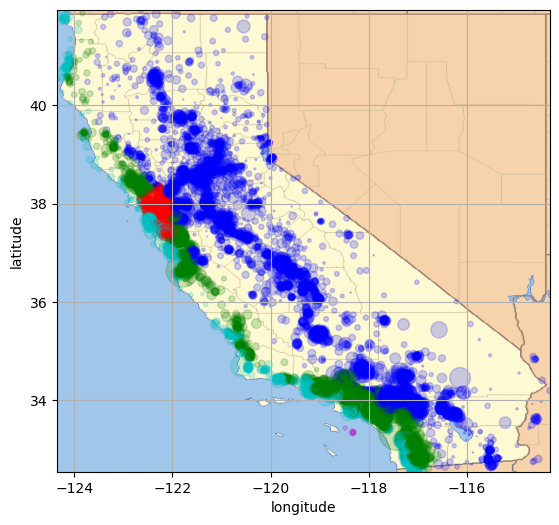

In [13]:
# It creates a California map where point color shows ocean proximity and point size shows local population.
color = {'NEAR BAY':'r', '<1H OCEAN':'g', 'INLAND':'b',
'NEAR OCEAN':'c', 'ISLAND':'m'}
data.plot(s=data['population']/50,figsize=(12,6)
           ,c=data.ocean_proximity.map(color),x='longitude',
          y='latitude',kind='scatter',alpha=0.2,grid=True)
img = plt.imread("california.png")
# axis = [xmin,xmax,ymin,ymax]
axis = (data.longitude.min(),data.longitude.max()
        ,data.latitude.min(),data.latitude.max())
plt.imshow(img,extent=axis)
plt.show()


In [14]:
# generates a quick statistical summary of all numerical columns in the dataset.
data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

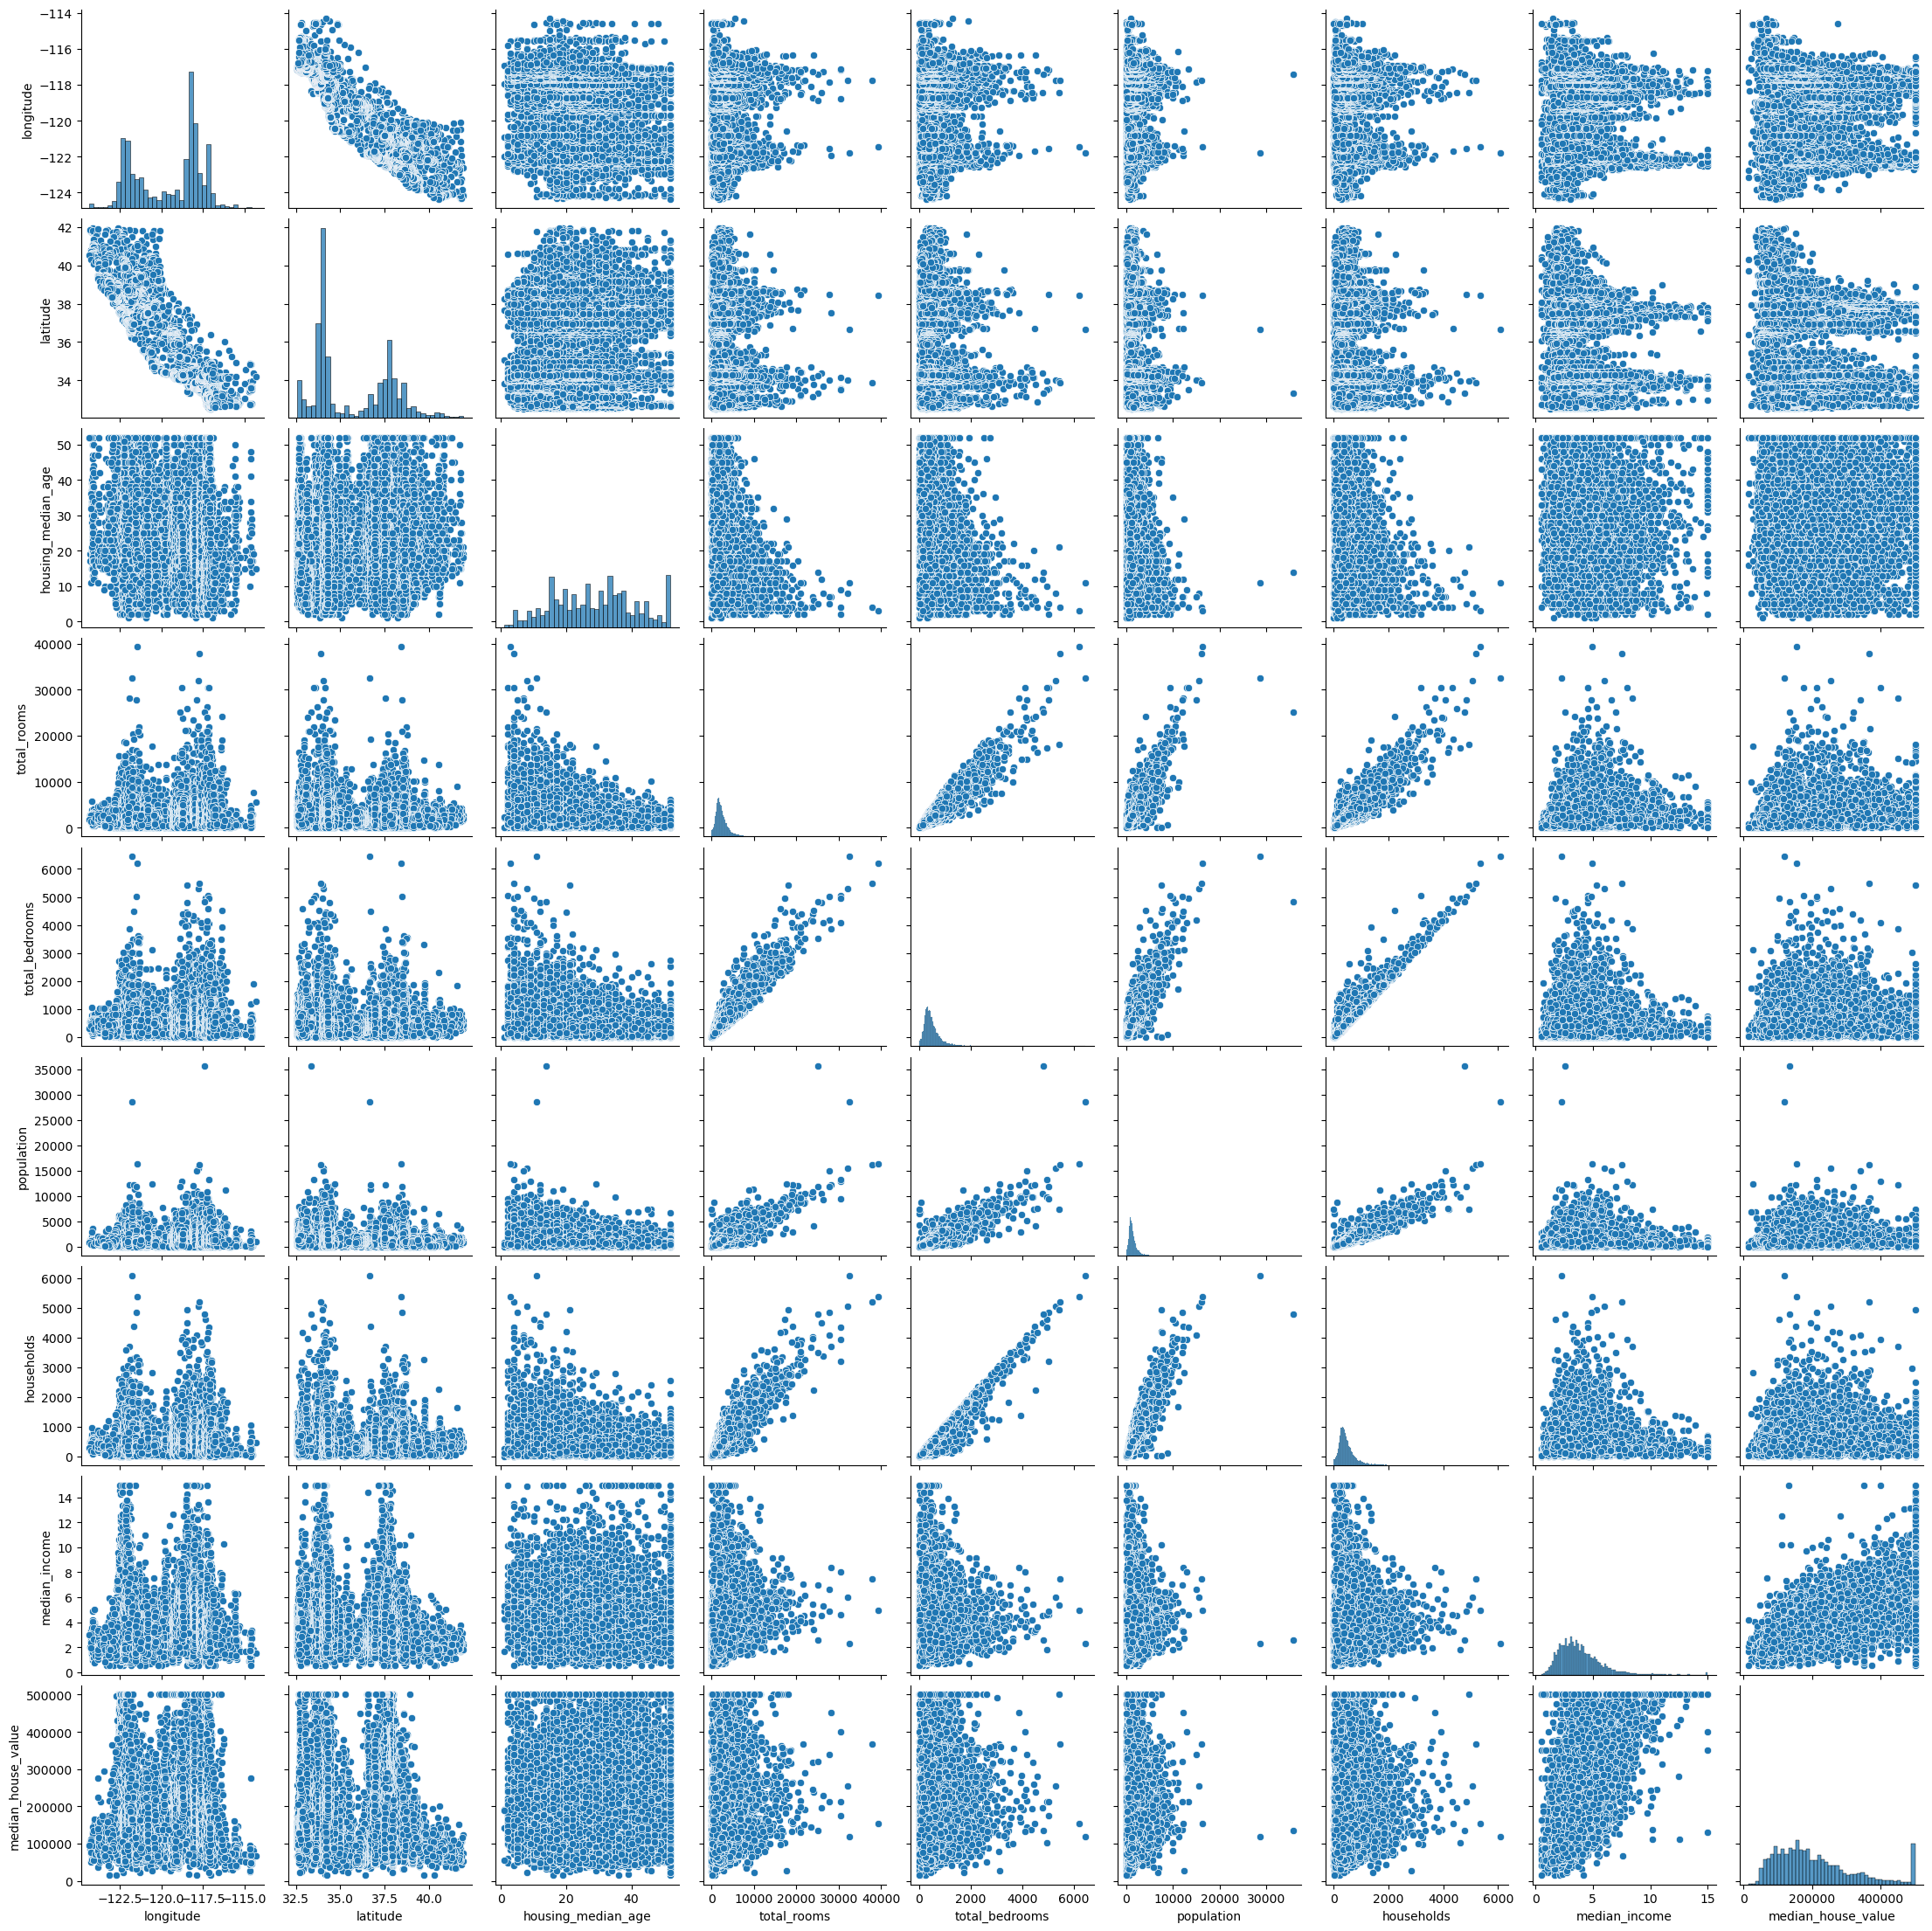

In [15]:
#creates a grid of scatter plots and histograms to show relationships between all numerical features in the dataset.
sns.pairplot(data)
plt.show()

In [16]:
#computes the correlation of every numeric column with median_house_value.
corr = data.corrwith(data['median_house_value'],numeric_only=True).sort_values(ascending=False,key=lambda x:abs(x))
corr

median_house_value    1.000000
median_income         0.688075
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
dtype: float64

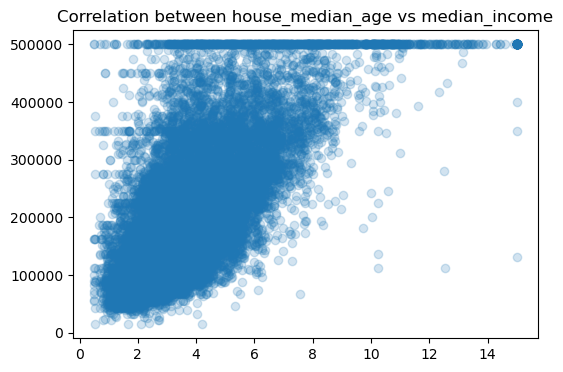

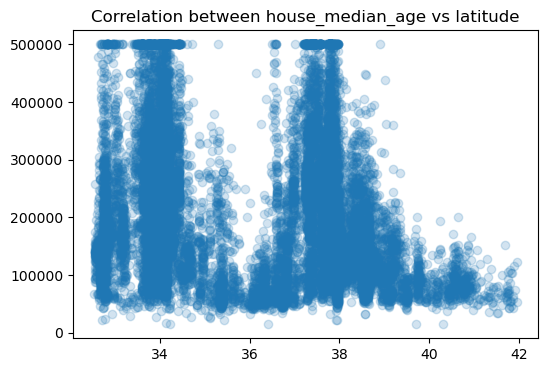

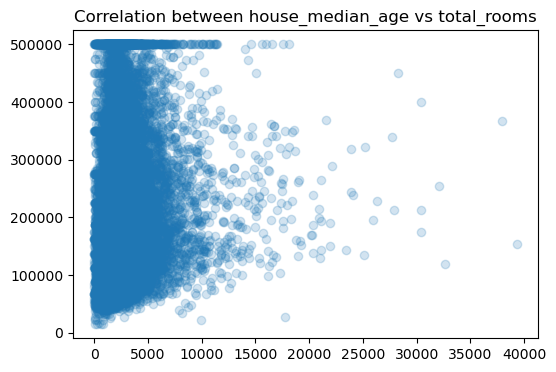

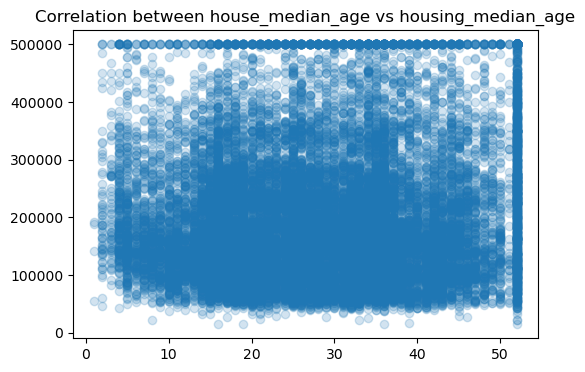

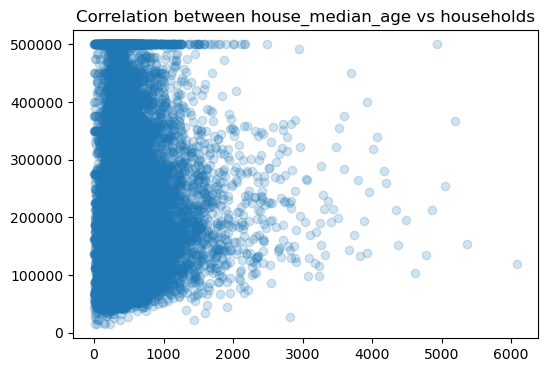

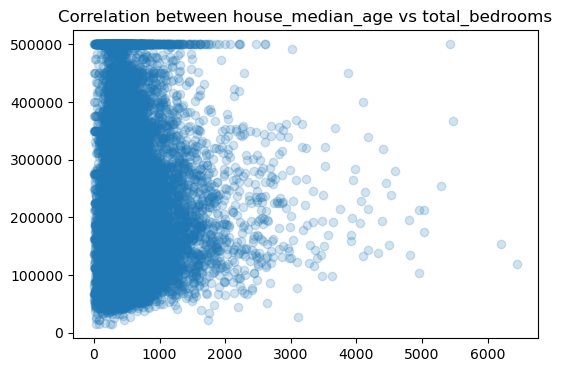

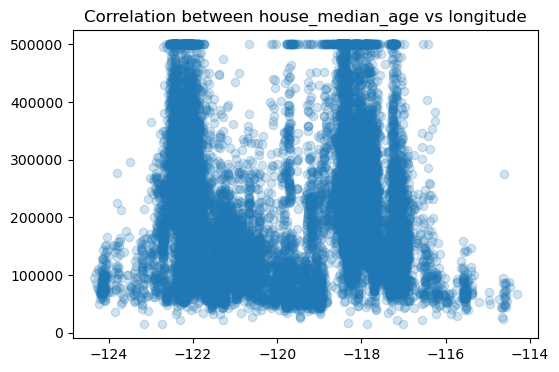

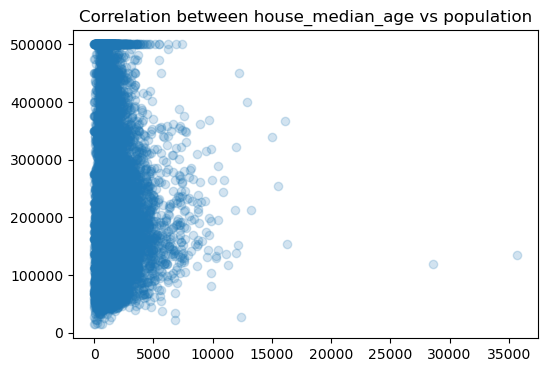

In [17]:
# This loop visualizes how each important feature relates to house prices.
for col in corr.index:
    if col != 'median_house_value':
        plt.figure(figsize=(6,4))
        plt.title(f"Correlation between house_median_age vs {col}")
        plt.scatter(data[col],data['median_house_value'],label=f"r={corr[col]:2f}",alpha=0.2)
        plt.show()

<Axes: >

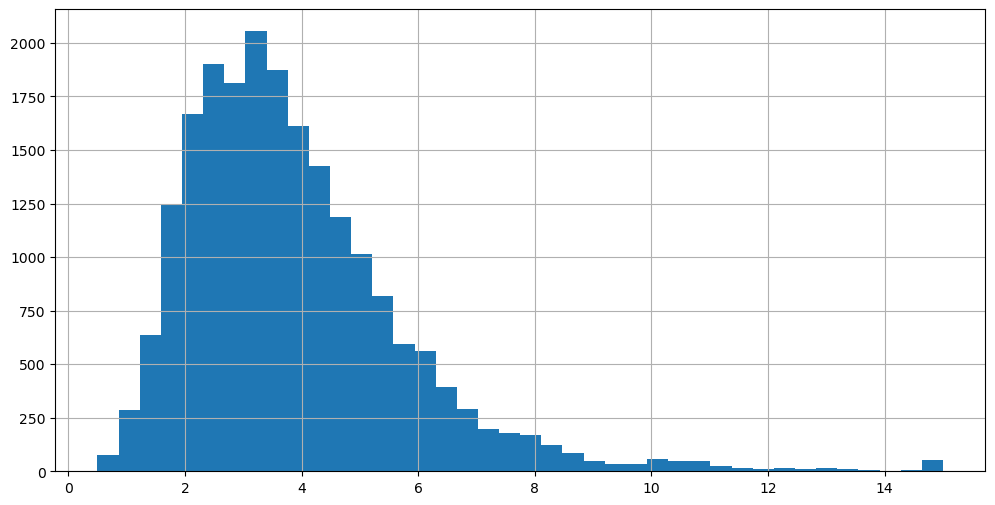

In [18]:
#This draws a histogram of median_income to show how incomes are distributed, using 40 bins on a wide figure.
data['median_income'].hist(bins=40,figsize=(12,6))

In [19]:
data['income_cat'] = pd.cut(data['median_income'],
                           bins = [0,2,4,6,8,10,12,np.inf],
                           labels=['poor','middle','upper_middle',
                                  'upper','rich','very_rich','ultra rich'])

#### This step converts continuous income into meaningful income groups.

pd.cut slices median_income into ranges like 0–2, 2–4, …, 10–12, and above 12, then creates a new column income_cat that labels each house as poor, middle, upper_middle, upper, rich, very_rich, or ultra_rich based on which income range it falls into.

<Axes: xlabel='income_cat'>

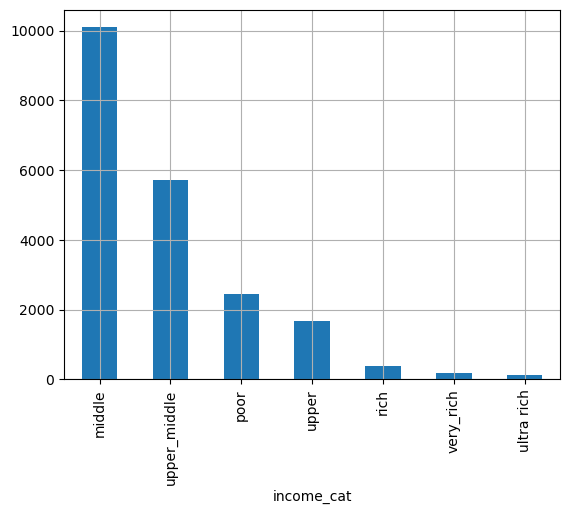

In [20]:
data['income_cat'].value_counts().plot(kind='bar',grid=True)

In [21]:
data.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

     income_cat  
0          rich  
1          rich  
2         upper  
3  upper_middle  
4        middle

In [22]:
#This line calculates how much of the dataset falls into each income category.
data.income_cat.value_counts()/data.shape[0]

income_cat
middle          0.489147
upper_middle    0.277374
poor            0.119041
upper           0.081008
rich            0.018508
very_rich       0.009448
ultra rich      0.005475
Name: count, dtype: float64

In [23]:
#This step creates a new feature that measures housing density per family.
data["rooms_per_households"] = data["total_rooms"] / data["households"]

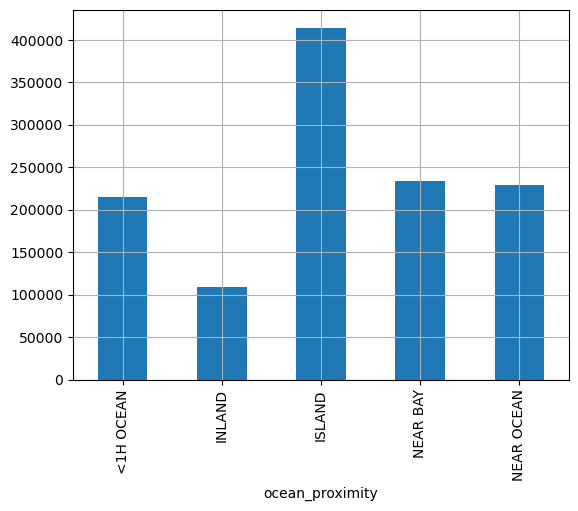

In [24]:
#Comparing typical house prices for each type of ocean proximity using a bar chart.

data.groupby("ocean_proximity",observed=False)["median_house_value"].median().plot(kind='bar', grid=True)
plt.show()

In [25]:
#This line creates a separate working copy of the dataset so experiments don’t affect the original data DataFrame.

temp  = data.copy()

In [26]:
temp.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat',
       'rooms_per_households'],
      dtype='object')

In [27]:
temp.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  rooms_per_households  
count        20640.000000          20640.000000  
mean        206855.816909              5.429000  
std         115395.615874              2.474173  
min          14999.000000              0.846154  
25%         119600.000000              4.440716  
50%         179700.000000              5.229129  
75%         264725.000000              6.052381  
max         500001.000000            141.909091

In [28]:
num_feature_without_outliers = ['longitude', 'latitude']
num_feature_with_outliers = ['housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income','rooms_per_households']
cat_feature = ['ocean_proximity']

#### This step groups columns by their type and behavior to guide preprocessing.

num_feature_without_outliers lists numeric features that look stable and don’t need heavy outlier handling.

num_feature_with_outliers lists numeric features that contain extreme values and may need scaling, capping, or transformation.

cat_feature stores the names of categorical columns, which will later be encoded instead of scaled like numeric features.

In [29]:
#This step separates the features from the target for modeling.

X = temp.drop(columns='median_house_value')
y = temp['median_house_value']

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=temp['income_cat'])

##### This line splits the data into balanced training and test sets.

It uses train_test_split to keep 80% of the rows for training and 20% for testing, while stratify=temp['income_cat'] ensures that the income categories are represented in the same proportion in both splits, and random_state=42 makes the split reproducible.

In [31]:
X_train = X_train.drop(columns='income_cat')
X_test = X_test.drop(columns='income_cat')

##### This step removes the helper stratification column before modeling.

income_cat was only needed to create balanced train–test splits, so it is dropped from X_train and X_test to ensure the model does not learn from this artificial catego

In [32]:
# This step defines a small helper function that creates a ratio feature from two columns.

def ratio(X, y=None):
    return X[:, [0]]/X[:, [1]]

#### This block builds a full preprocessing pipeline that prepares all features for the model in one shot.

Several mini‑pipelines are defined first:

outlier_pipeline: for numeric columns with outliers, it fills missing values with the median, applies a log transform to reduce skewness, then standardizes the values.

without_outlier_pipeline: for stable numeric columns, it fills missing values with the median and directly standardizes them.

cat_pipeline: for categorical columns, it fills missing values with the most frequent category and then one‑hot encodes them into dummy variables.

add_feature: for ratio features, it imputes medians, computes the ratio using ratio (e.g., rooms per household), then standardizes that new feature.

inner_pipeline = ColumnTransformer([...]) ties everything together:

It sends the “with outliers” numeric columns through outlier_pipeline.

It sends the “without outliers” numeric columns through without_outlier_pipeline.

It sends categorical columns through cat_pipeline.

It creates two engineered ratio features:

"rooms per household" from ["total_rooms", "households"] using add_feature.

"bedrooms per households" from ["total_bedrooms", "households"] using add_feature.

In [33]:
outlier_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log),
    StandardScaler())

without_outlier_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder())

add_feature = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(ratio),
    StandardScaler())

inner_pipeline = ColumnTransformer([
    ("Numerical with Outlier: ", outlier_pipeline, num_feature_with_outliers),
    ("Numerical without Outlier: ", without_outlier_pipeline ,num_feature_without_outliers),
    ("Categorial: ", cat_pipeline, cat_feature),
    ("rooms per household", add_feature, ["total_rooms", "households"]),
    ("bedrooms per households", add_feature, ["total_bedrooms", "households"]),
])

#### This creates a single end‑to‑end model that includes preprocessing and linear regression together.

In [34]:
full_pipeline = Pipeline([
    ("Pipeline: ",inner_pipeline),
    (" model ", LinearRegression())
])

In [35]:
full_pipeline

Pipeline(steps=[('Pipeline: ',
                 ColumnTransformer(transformers=[('Numerical with Outlier: ',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   '...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_rooms',
                                                   'households']),
                                                 ('bedrooms per households',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function ratio at 0x000002488A8004A0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'households'])])),
                (' model ', LinearRegression())])

In [36]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Pipeline: ',
                 ColumnTransformer(transformers=[('Numerical with Outlier: ',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   '...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_rooms',
                                                   'households']),
                                                 ('bedrooms per households',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function ratio at 0x000002488A8004A0>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'households'])])),
                (' model ', LinearRegression())])

In [37]:
#This line generates model predictions for the training data using the entire pipeline.

y_pred_train = full_pipeline.predict(X_train)

In [38]:
y_train[:5].to_numpy()

array([246600., 137500., 185100., 161200., 108200.])

In [39]:
np.round(y_pred_train[:5],0)

array([272325., 222227., 222021., 177450., 156586.])

In [40]:
y_pred_test = full_pipeline.predict(X_test)
np.round(y_pred_test[:5],0)

array([263711., 219323.,  82515., 282566., 239347.])

In [41]:
np.round(abs((y_test - y_pred_test)[:5].to_numpy()),0)

array([41811., 79023., 17785.,  5566., 17847.])

#### This function trains several models using the same pipeline, evaluates them, and prints a neat comparison table.

It loops over a dictionary of models, and for each one builds a fresh full_pipeline that first applies inner_pipeline (all preprocessing) and then the current ML model.

For each model, it fits on X_train, y_train, predicts on both train and test sets, and computes RMSE, RMSE as a percentage of the mean target, and R² score for train and test.

The metrics and model name are stored in a performance list of dictionaries.

At the end, it prints a formatted table where each row shows one model with its train/test errors and accuracies, so you can quickly compare which algorithm performs best.

In [42]:
def evaulate(models):
    performance = [] # {"name":"Linear Regression", "train error": 30000, "test error": 40000, "train accuray": 70, "test_accuracy": 50, }
    for model_name, model in models.items():
        full_pipeline = Pipeline([
            ("pipeline", inner_pipeline), # prepare data for ML model
            ("model", model() ) # ML Model
        ])
        # train Error Estimation
        print(f"Training Model {model_name}")
        full_pipeline.fit(X_train, y_train)
        y_train_hat = full_pipeline.predict(X_train)
        train_error = np.sqrt(mean_squared_error(y_train, y_train_hat))
        train_error_percent = (train_error / y_train.mean())*100
        train_acc = r2_score(y_train, y_train_hat)*100
        # Test Error Estimation
        y_test_hat = full_pipeline.predict(X_test)
        test_error = np.sqrt(mean_squared_error(y_test, y_test_hat))
        test_error_percent = (test_error / y_test.mean())*100
        test_acc = r2_score(y_test, y_test_hat)*100
        performance.append({
             "name": model_name,
            "train error": round(train_error, 2), 
            "train error%": round(train_error_percent, 2), 
            "train acc": round(train_acc, 2),
            "test error": round(test_error, 2), 
            "test error%": round(test_error_percent, 2),
            "test acc": round(test_acc, 2),
        })

    print("_"*120)
    print(f"|{'Model Name':^40}|{'Train Error':^12}|{'Test Error':^12}|{'Train Error%':^12}|{'Test Error%':^12}|{'Train Acc':^10}|{'Test Acc':^10}|".center(100))
    # 8 pipes + 88 
    print("_"*120)
    for d in performance:
        print(f"|{d['name']:^40}|{d['train error']:^12}|{d['test error']:^12}|{d['train error%']:^12}|{d['test error%']:^12}|{d['train acc']:^10}|{d['test acc']:^10}|".center(100))
        print("-"*120)

#### This dictionary is a catalog of regression algorithms that will be passed into the evaluate function.

Each key is a readable model name string, and each value is the corresponding scikit‑learn regressor class (Linear Regression, Decision Tree, SVR, Random Forest), so the loop can instantiate and train all these models using the same preprocessing pipeline and compare their performance.

In [43]:
models = {
    "Linear Regression": LinearRegression,
    "Ranodm Forest Regresoor: ": RandomForestRegressor,
    "XGBoost Model: ": XGBRegressor
}

#### evaluate(models) now runs all the defined algorithms, measures how well they predict prices, and prints a scorecard.

In [44]:
evaulate(models)

Training Model Linear Regression
Training Model Decision Tree Regressor: 
Training Model Support Vector Machine Regressor: 
Training Model Ranodm Forest Regresoor: 
Training Model XGBoost Model: 
________________________________________________________________________________________________________________________
|               Model Name               |Train Error | Test Error |Train Error%|Test Error% |Train Acc | Test Acc |
________________________________________________________________________________________________________________________
|           Linear Regression            |  71692.58  |  70587.52  |   34.57    |   34.49    |  61.66   |  61.51   |
------------------------------------------------------------------------------------------------------------------------
|       Decision Tree Regressor:         |    0.0     |  68961.04  |    0.0     |    33.7    |  100.0   |  63.26   |
------------------------------------------------------------------------------------------

In [ ]:
data = {'model': your_trained_model, 'features': feature_names}
with open('model.pkl', 'wb') as f:
    pickle.dump(data, f)  # Serialize to binary file
